# GridCure Application Problem
## Initial Exploration

## Electric Vehicle Detection

The training set contains two months of smart meter power readings from 1590 houses.  The readings were taken at half-hour intervals.  Some of the homes have electric vehicles and some do not.   The file  "EV_train_labels.csv" indicates the time intervals on which an electric vehicle was charging (1 indicates a vehicle was charging at some point during the interval and 0 indicates no vehicle was charging at any point during the interval).  Can you determine:

A.	Which residences have electric vehicles?  
B.	When the electric vehicles were charging?  
C.	Any other interesting aspects of the dataset?  

A solution to part B might consist of a prediction of the probability that an electric car was charging for each house and time interval in the test set.  Please include code and explain your reasoning.  What do you expect the accuracy of your predictions to be?


In [1]:
# File Setup
from pathlib import Path
import pandas as pd


In [2]:
data_folder = Path('../../EV_files')

# Test Data
file_evtest = data_folder / "EV_test.csv"
test = pd.read_csv(file_evtest, index_col='House ID')

# Train Data
file_evtrain = data_folder / "EV_train.csv"
train = pd.read_csv(file_evtrain, index_col='House ID')

# Train Labels
file_evlabels = data_folder / "EV_train_labels.csv"
labels = pd.read_csv(file_evlabels, index_col='House ID')


In [3]:
print("Data Frame Shapes")
print("Test: {}".format(test.shape))
print("Train: {}".format(train.shape))
print("Labels: {}".format(labels.shape))

Data Frame Shapes
Test: (699, 2880)
Train: (1590, 2880)
Labels: (1590, 2880)


## A. Which Residences have electric vehicles?

In [11]:
# The file  "EV_train_labels.csv" indicates the time intervals on which an electric vehicle was charging

# Sum across labels df to determine how many times each house charged an electric car
df_a = pd.DataFrame(labels.sum(axis=1))
df_a.rename(columns= {0: 'sum'}, inplace=True)

# Map the sums to Booleans
# True - Electric car was charged one or more times at the given house
# False - No electic cars charged at the 
df_a['bool'] = df_a['sum'].where(df_a['sum'] == 0, other=1)
df_a['bool'].replace({0:False, 1:True}, inplace=True)

print(df_a.head())

          sum   bool
House ID            
11655099    0  False
11633257    0  False
11651552    0  False
11636092    0  False
11647239  117   True


In [12]:
# Simple Data Summary
print("Summary Stats for all Households")
print("Min Charges: {} (Should be 0 to account for houses without E-Cars.)".format(df_a['sum'].min()))
print("Max Charges: {}\n".format(df_a['sum'].max()))

counts = df_a['bool'].value_counts(sort=True)
tot = df_a.shape[0]
# print(counts)

print("{0:.1f}% of houses do not charge E-Cars.".format(counts[False]/tot*100))
print("{0:.1f}% of houses do charge E-Cars.".format(counts[True]/tot*100))

Summary Stats for all Households
Min Charges: 0 (Should be 0 to account for houses without E-Cars.)
Max Charges: 685

69.5% of houses do not charge E-Cars.
30.5% of houses do charge E-Cars.


In [13]:
# Non-Zero Summary Statistics
df_aT = df_a.loc[df_a['bool'] == True]
# print(df_aT.shape)
# print(df_aT.head())
desc = df_aT['sum'].describe()
print("Summary Stats for E-Car Households")
print("{0:.0f} Houses charge E-Cars".format(desc['count']))
print("Min Charges: {0:.0f}".format(desc['min']))
print("Max Charges: {0:.0f}".format(desc['max']))
print("Average Charges: {0:.0f}".format(desc['mean']))


Summary Stats for E-Car Households
485 Houses charge E-Cars
Min Charges: 71
Max Charges: 685
Average Charges: 220


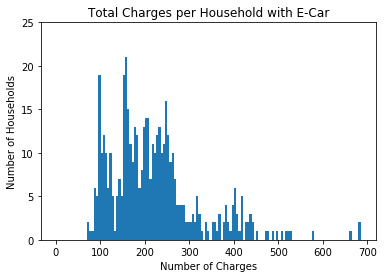

In [14]:
# Distribution of Charges per Household
import matplotlib.pyplot as plt

ax = df_aT.plot(kind='hist', 
          by='sum', 
          bins=137, 
          ylim=[0,25],
          legend=False)
ax.set(
    title='Total Charges per Household with E-Car',
    xlabel="Number of Charges", 
    ylabel="Number of Households",
    autoscalex_on=True)

plt.show()

In [15]:
# TODO: Appears to be a bimodal distribution, could analyze further

### Build model to predict which household has E-Car
Features: Meter Readings  
Classification: E-Car, Boolean
Supervised Binomial Classification

After exploring: 
* Logistic Regression . 
* Random Forests . 
* K-Nearest Neighbors . 

Logistic regression and Random Forests can be tuned to equivalent performance. KNN does not perform well. 

In [16]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [30]:
# Split into features and classifications
X = train.copy(deep=True)
y = df_a['bool']

from collections import namedtuple
df_summary = namedtuple('df_summary', 
                        ['rows', 'cols', 'idx_list'])

# Drop NA-containing rows from X
before = df_summary(X.shape[0], X.shape[1], X.index.tolist())
X = X.dropna()
after = df_summary(X.shape[0], X.shape[1], X.index.tolist())
print("{} Rows were dropped for NA reasons.".format(before.rows - after.rows))

# Drop corresponsing rows from y
removed_idx = []
for house_id in before.idx_list: 
    if house_id not in after.idx_list: 
        removed_idx.append(house_id)
y = y.drop(index=removed_idx)

# Quick validation
print(y.shape, X.shape)

4 Rows were dropped for NA reasons.
(1586,) (1586, 2880)
<class 'pandas.core.frame.DataFrame'>
(1586, 2880)


In [31]:
print(type(X))
print(X.shape)

# Scale the features between -1 and 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)                                    
X_scaled = scaler.transform(X)


<class 'pandas.core.frame.DataFrame'>
(1586, 2880)


In [19]:
# Split data into training and testing
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    random_state=0)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(1189, 2880) (397, 2880)
(1189,) (397,)


In [20]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Solver = ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.83


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


          score
trees          
2.0    0.677582
10.0   0.798489
20.0   0.795970
50.0   0.818640
100.0  0.818640


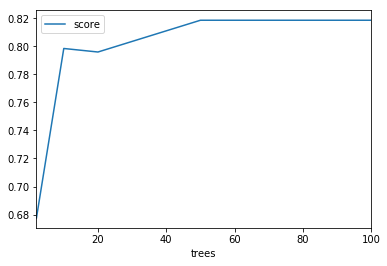

In [21]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

df_test = pd.DataFrame(columns=['trees', 'score'])
for n in [2, 10, 20, 50, 100]:
    # Create a random forest Classifier. By convention, clf means 'Classifier'
    clf = RandomForestClassifier(n_jobs=10, 
                                 max_depth=n,
                                 min_samples_split=5,
                                 max_features='log2',
                                 random_state=0)

    # Train the Classifier to take the training features and learn how they relate
    # to the training y (the species)
    clf.fit(X_train, y_train)

    # Apply the Classifier we trained to the test data (which, remember, it has never seen before)
    score = clf.score(X_test, y_test)
    df_test = df_test.append({'trees':n, 'score':score}, ignore_index=True)

df_test = df_test.set_index('trees')
df_test.plot()

print(df_test)

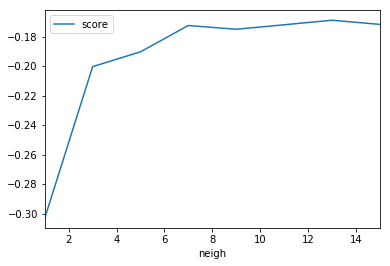

In [22]:
# KNN Model
# Performance of the KNN is model very poor
from sklearn.neighbors import KNeighborsRegressor

df_test = pd.DataFrame(columns=['neigh', 'score'])
for n in [1, 3, 5, 7, 9, 11, 13, 15]: 
    # Look at the n closest neighbors.
    knn = KNeighborsRegressor(n_neighbors=n)
    # Fit the model on the training data.
    knn.fit(X_train, y_train)
    # Make point predictions on the test set using the fit model.
    # Returns the coefficient of determination R^2 of the prediction.
    score = knn.score(X_test, y_test)
    y_pred = knn.predict(X_test)
    score = metrics.r2_score(y_test, y_pred)
    # score = metrics.accuracy_score()
    df_test = df_test.append({'neigh':n, 'score':score}, ignore_index=True)

df_test = df_test.set_index('neigh')
df_test.plot()

### Testing feature engineering 

In [23]:
# Calculate the change in demand between each time point (d-use/d-time)
train_diff = pd.DataFrame(index=train.index)
cols = sorted(list(train.columns.values))

for i, c2 in enumerate(cols): 
    if i == 0: pass # Skip the first element
    c1 = cols[i-1]
    train_diff[c2] = pd.DataFrame(abs(train[c2] - train[c1]))

# print(train_diff.head())


In [24]:

train_eng = pd.DataFrame(index=train.index)
# train_eng['sum'] = pd.DataFrame(train.sum(axis=1))
# train_eng['min'] = pd.DataFrame(train.min(axis=1))
train_eng['max'] = pd.DataFrame(train.max(axis=1))
train_eng['avg'] = pd.DataFrame(train.mean(axis=1))

print(train_eng.head())

               max       avg
House ID                    
11655099  2.170000  0.569631
11633257  3.842000  0.667629
11651552  4.788000  0.659690
11636092  4.119000  1.397184
11647239  6.993877  1.423121


In [25]:
train_eng['diff_max'] = pd.DataFrame(train_diff.max(axis=1))
train_eng['diff_sum'] = pd.DataFrame(train_diff.sum(axis=1))
train_eng['diff_sum'] = pd.DataFrame(train_diff.sum(axis=1))
print(train_eng.head())

               max       avg  diff_max    diff_sum
House ID                                          
11655099  2.170000  0.569631  1.672000   537.84400
11633257  3.842000  0.667629  3.513000   619.08200
11651552  4.788000  0.659690  4.112000  1156.64000
11636092  4.119000  1.397184  3.140000   939.59000
11647239  6.993877  1.423121  5.774877   406.34037


In [26]:
# Split into features and classifications
X = train_eng
y = df_a['bool']

# Scale the features between -1 and 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)                                    
X_scaled = scaler.transform(X)

from collections import namedtuple
df_summary = namedtuple('df_summary', 'rows cols idx_list')

# Drop NA-containing rows from X
before = df_summary(X.shape[0], X.shape[1], X.index.tolist())
X = X.dropna()
after = df_summary(X.shape[0], X.shape[1], X.index.tolist())
print("{} Rows were dropped for NA reasons.".format(before.rows - after.rows))

# Drop corresponsing rows from y
removed_idx = []
for house_id in before.idx_list: 
    if house_id not in after.idx_list: 
        removed_idx.append(house_id)
y = y.drop(index=removed_idx)

# Quick validation
# print(y.shape, X.shape)

# Split data into training and testing
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    random_state=0)

# print(X_train.shape, X_test.shape)
# print(y_train.shape, y_test.shape)

0 Rows were dropped for NA reasons.


In [27]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Solver = ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.76
